#### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import folium # map rendering library

from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
import seaborn as sns

#### Get the raw content of Amsterdam wiki page

In [2]:
# Get the raw content of Amsterdam wiki page
wikipedia_link='https://en.wikipedia.org/wiki/Boroughs_of_Amsterdam'
raw_random_wikipedia_page = requests.get(wikipedia_link)
page = raw_random_wikipedia_page.text

#### Extract the Amsterdam borough table using BeautifulSoup

In [3]:
# Extract the Amsterdam table using BeautifulSoup
ams_soup = BeautifulSoup(page)
ams_table = ams_soup.find('table', class_='wikitable sortable')

#### Transform the BeautifulSoup table to a dataframe

In [4]:
# Transform the BeautifulSoup table to a dataframe
df = pd.read_html(str(ams_table))[0]
df

,Borough,Area,Population,Population density,Location (in green)
0,Centrum (Centre),8.04 km²,86422,"13,748/km²",NaN
1,Noord (North),49.01 km²,94766,"2,269/km²",NaN
2,Nieuw-West(New West),32.38 km²,151677,"4,478/km²",NaN
3,Oost (East),30.56 km²,135767,"7,635/km²",NaN
4,West,9.89 km²,143842,"15,252/km²",NaN
5,Westpoort(West Gateway),10 km²,192,10/km²,NaN
6,Zuid (South),17.41 km²,144432,"9,349/km²",NaN
7,Zuidoost(Southeast),22.08 km²,87854,"4,391/km²",NaN


#### Data Preprocessing  
1. Trim contents inside brackets; remove ‘km2’ and cast strings into numeric data types.
2. Remove 'Westpoort' since it is mainly a harbour and has very few permanent inhabitants.

In [5]:
# Trim contents inside brackets
df['Borough'] = df['Borough'].apply(lambda x:x if x.find('(') == -1 else x[0:x.find('(')].strip())
# Remove ‘km2’ and cast string into float
df['Area'] = df['Area'].apply(lambda x: x[0:x.find('km')]).astype(float)
# Remove ‘km2’ and cast string into int
df['PopulationDensity'] = df['Population density'].apply(lambda x: x[0:x.find('/km')].replace(',','')).astype(int)
df.drop(["Population density", "Location (in green)"], axis=1, inplace=True)

# Remove'Westpoort' since it is mainly a harbour and has very few permanent inhabitants.
df = df.drop([5]).reset_index(drop=True)
df

,Borough,Area,Population,PopulationDensity
0,Centrum,8.04,86422,13748
1,Noord,49.01,94766,2269
2,Nieuw-West,32.38,151677,4478
3,Oost,30.56,135767,7635
4,West,9.89,143842,15252
5,Zuid,17.41,144432,9349
6,Zuidoost,22.08,87854,4391


Obtain latitude, longitude of each borough using geopy package and concatenate to the borough dataframe

In [6]:
# Obtain latitude, longitude of each borough using geopy package and concatenate to the borough dataframe
geolocator = Nominatim(user_agent="explore_amsterdam")
borough_locations = df['Borough'].apply(lambda x: x + ', Amsterdam, the Netherlands').apply(geolocator.geocode)
df[['Latitude', 'Longitude']] = borough_locations.apply(lambda x: (x.latitude, x.longitude)).apply(pd.Series)
df

,Borough,Area,Population,PopulationDensity,Latitude,Longitude
0,Centrum,8.04,86422,13748,52.373730,4.895691
1,Noord,49.01,94766,2269,52.401739,4.915352
2,Nieuw-West,32.38,151677,4478,52.363777,4.813812
3,Oost,30.56,135767,7635,52.356608,4.930577
4,West,9.89,143842,15252,52.376672,4.863724
5,Zuid,17.41,144432,9349,52.344470,4.878664
6,Zuidoost,22.08,87854,4391,52.310514,4.960695


#### Get venues around Boroughs (within 1 km radius of each borough center)

In [7]:
# Define Foursquare Credentials and Version
CLIENT_ID = '3W4WIVY453MAWA3SMLL2MY3OY0NBWB3TDCBLASXJ4RFXH2CP'
CLIENT_SECRET = 'NNWKMCE0TFL0BTUVA5GD5S0F5GJE5QL5DHSQOLLAXDL0IVOZ'
VERSION = '20180605' # Foursquare API version

print('The Foursquare credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

The Foursquare credentails:
CLIENT_ID: 3W4WIVY453MAWA3SMLL2MY3OY0NBWB3TDCBLASXJ4RFXH2CP
CLIENT_SECRET:NNWKMCE0TFL0BTUVA5GD5S0F5GJE5QL5DHSQOLLAXDL0IVOZ


In [8]:
# Define a function to get venues around a certain location
def getNearbyVenues(names, latitudes, longitudes, radius=1000, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough_Latitude', 
                  'Borough_Longitude', 
                  'Venue_ID',           
                  'Venue_Name', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
    return(nearby_venues)

In [9]:
# Define a function to get venue ratings, pricr tiers and etc.
def getVenueDetails(venue_id):
    
    # rating, price and price_tier
    venue_details = [np.nan, np.nan, np.nan]
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
        venue_id,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)
   
    # print(url)
    
    # make the GET request
    results = requests.get(url).json()
    
    if results and ('response' in results) and ('venue' in results['response']):
        if 'rating' in results['response']['venue']:
            rating = results['response']['venue']['rating']
            venue_details[0] = rating
        if 'price' in results['response']['venue']:
            if 'message' in results['response']['venue']['price']:
                price = results['response']['venue']['price']['message']
                venue_details[1] = price
            if 'tier' in results['response']['venue']['price']:
                price_tier = results['response']['venue']['price']['tier']
                venue_details[2] = price_tier
        
    return venue_details    

In [31]:
# Obtain the venues within 1 km radius of each borough center
ams_venues = getNearbyVenues(names=df['Borough'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'],
                                   radius = 1000,
                                   limit=200
                                  )
ams_venues.head()

,Borough,Borough_Latitude,Borough_Longitude,Venue_ID,Venue_Name,Venue_Latitude,Venue_Longitude,Venue_Category
0,Centrum,52.37373,4.895691,51d98583498e78da6626be60,De Koffieschenkerij,52.374043,4.898427,Coffee Shop
1,Centrum,52.37373,4.895691,4a270317f964a52075841fe3,Wynand Fockink,52.372301,4.895253,Liquor Store
2,Centrum,52.37373,4.895691,4b9ff646f964a520f44d37e3,Dam,52.372824,4.893702,Plaza
3,Centrum,52.37373,4.895691,514dd657e4b0579579288eef,Old Amsterdam Cheese Store,52.374862,4.895301,Cheese Shop
4,Centrum,52.37373,4.895691,51c5cc0a498e570ebbb6a807,Cut Throat,52.374486,4.895623,Salon / Barbershop


In [32]:
ams_venues.shape

(546, 8)

In [33]:
ams_venues.to_csv('ams_venus_radius_1000_limit_200.csv', index=False)

The venues are filtered based on venue category: only venues with category keyword ‘Restaurant’ are preserved. Moreover, ‘Sushi Restaurant’ and ‘Ramen Restaurant’ in the venue category are re-labelled with ‘Japanese Restaurant’.

In [38]:
# The venues are filtered based on venue category: 
# only venues with category keyword ‘Restaurant’ are preserved. 
ams_restaurant = ams_venues[ams_venues['Venue_Category'].str.contains('Restaurant')].reset_index(drop=True)

#‘Sushi Restaurant’ and ‘Ramen Restaurant’ in the venue category are re-labelled with ‘Japanese Restaurant’.
ams_restaurant['Venue_Category'] = ams_restaurant['Venue_Category'].apply(lambda x: 'Japanese Restaurant' \
                                       if (x.find('Sushi') != -1 or x.find('Ramen') != -1) \
                                       else x)
ams_restaurant.head()

,Borough,Borough_Latitude,Borough_Longitude,Venue_ID,Venue_Name,Venue_Latitude,Venue_Longitude,Venue_Category
0,Centrum,52.37373,4.895691,5648c396498edda4852d4c23,La Zoccola del Pacioccone,52.375297,4.893965,Italian Restaurant
1,Centrum,52.37373,4.895691,55e5ff02498e9eb3a234f62c,Kaagman & Kortekaas,52.374878,4.892455,French Restaurant
2,Centrum,52.37373,4.895691,53e8efc1498ea17469974c4b,Wok to Walk,52.372014,4.895579,Asian Restaurant
3,Centrum,52.37373,4.895691,4a2707d2f964a520ec8e1fe3,Oriental City,52.371912,4.895994,Chinese Restaurant
4,Centrum,52.37373,4.895691,514e0cbce4b0679548f4d62a,The Lobby,52.371159,4.893661,Restaurant


In [35]:
ams_restaurant.shape

(145, 8)

In [39]:
print(ams_restaurant['Venue_Category'].value_counts())

Restaurant                         21
Italian Restaurant                 19
French Restaurant                  12
Chinese Restaurant                  9
Turkish Restaurant                  8
Asian Restaurant                    8
Japanese Restaurant                 8
Thai Restaurant                     7
Fast Food Restaurant                6
Vegetarian / Vegan Restaurant       5
Indonesian Restaurant               4
Mediterranean Restaurant            3
Seafood Restaurant                  2
Caribbean Restaurant                2
Indian Restaurant                   2
Comfort Food Restaurant             2
Scandinavian Restaurant             2
Falafel Restaurant                  2
Greek Restaurant                    2
North Indian Restaurant             1
Dutch Restaurant                    1
Tapas Restaurant                    1
Modern European Restaurant          1
Doner Restaurant                    1
Latin American Restaurant           1
Caucasian Restaurant                1
Persian Rest

In [40]:
# Number of unique venue categories 
print('There are {} unique categories.'.format(len(ams_venues['Venue_Category'].unique())))

There are 154 unique categories.


In [41]:
# Number of unique venue categories 
print('There are {} unique restaurant categories.'.format(len(ams_restaurant['Venue_Category'].unique())))

There are 40 unique restaurant categories.


#### Obtain restaurant ratings, price levels for the restaurants of the 7 Amsterdam boroughs

In [42]:
# Obtain restaurant ratings, price levels for the restaurants of the 7 Amsterdam boroughs
ams_restaurant['Rating'], ams_restaurant['Price'], ams_restaurant['Price_Tier'] = \
        zip(*ams_restaurant['Venue_ID'].map(getVenueDetails))

In [47]:
ams_restaurant.shape

(145, 11)

In [48]:
ams_restaurant.head()

,Borough,Borough_Latitude,Borough_Longitude,Venue_ID,Venue_Name,Venue_Latitude,Venue_Longitude,Venue_Category,Rating,Price,Price_Tier
0,Centrum,52.37373,4.895691,5648c396498edda4852d4c23,La Zoccola del Pacioccone,52.375297,4.893965,Italian Restaurant,8.8,Moderate,2.0
1,Centrum,52.37373,4.895691,55e5ff02498e9eb3a234f62c,Kaagman & Kortekaas,52.374878,4.892455,French Restaurant,9.0,Expensive,3.0
2,Centrum,52.37373,4.895691,53e8efc1498ea17469974c4b,Wok to Walk,52.372014,4.895579,Asian Restaurant,8.6,Moderate,2.0
3,Centrum,52.37373,4.895691,4a2707d2f964a520ec8e1fe3,Oriental City,52.371912,4.895994,Chinese Restaurant,8.4,Moderate,2.0
4,Centrum,52.37373,4.895691,514e0cbce4b0679548f4d62a,The Lobby,52.371159,4.893661,Restaurant,9.1,Moderate,2.0


In [46]:
# save restaurant rating and price into a csv file
ams_restaurant.to_csv('ams_restaurant_rating_price.csv', index=False)

In [10]:
#ams_restaurant = pd.read_csv('ams_restaurant_rating_price.csv')
ams_restaurant.drop(columns=['Venue_ID'], inplace=True)
ams_restaurant.head()

,Borough,Borough_Latitude,Borough_Longitude,Venue_Name,Venue_Latitude,Venue_Longitude,Venue_Category,Rating,Price,Price_Tier
0,Centrum,52.37373,4.895691,La Zoccola del Pacioccone,52.375297,4.893965,Italian Restaurant,8.8,Moderate,2.0
1,Centrum,52.37373,4.895691,Kaagman & Kortekaas,52.374878,4.892455,French Restaurant,9.0,Expensive,3.0
2,Centrum,52.37373,4.895691,Wok to Walk,52.372014,4.895579,Asian Restaurant,8.6,Moderate,2.0
3,Centrum,52.37373,4.895691,Oriental City,52.371912,4.895994,Chinese Restaurant,8.4,Moderate,2.0
4,Centrum,52.37373,4.895691,The Lobby,52.371159,4.893661,Restaurant,9.1,Moderate,2.0


# Exploratory data analysis

#### 1. Explore the number of restaurants and population-restaurant ratios of 7 boroughs

1.1. Calculate the number of restaurants and population-restaurant ratio of each borough

In [11]:
# Calculate the number of restaurants of each borough
ams_rest_cnt_df = ams_restaurant.groupby('Borough').size().reset_index()
ams_rest_cnt_df.columns=['Borough','Restaurant_Count']

In [12]:
# Calculate population-restaurant ratio (averge population per restaurant)
ams_rest_cnt_df = ams_rest_cnt_df.merge(df[['Borough','PopulationDensity']])
# 1 km radius, square: np.pi * 1^2
ams_rest_cnt_df['Avg_Population_per_Restaurant'] = (ams_rest_cnt_df['PopulationDensity']*np.pi/ams_rest_cnt_df['Restaurant_Count']).astype(int)

ams_rest_cnt_df

,Borough,Restaurant_Count,PopulationDensity,Avg_Population_per_Restaurant
0,Centrum,16,13748,2699
1,Nieuw-West,9,4478,1563
2,Noord,9,2269,792
3,Oost,34,7635,705
4,West,33,15252,1451
5,Zuid,27,9349,1087
6,Zuidoost,17,4391,811


1.2. Visualize restaurant counts of 7 boroughs using a barplot graph

In [14]:
# Sort restaurant counts of 7 boroughs
ams_rest_cnt_df_sorted = ams_rest_cnt_df.sort_values(by=['Restaurant_Count'], ascending=False)
ams_rest_cnt_df_sorted = ams_rest_cnt_df_sorted.reset_index(drop=True)
ams_rest_cnt_df_sorted

,Borough,Restaurant_Count,PopulationDensity,Avg_Population_per_Restaurant
0,Oost,34,7635,705
1,West,33,15252,1451
2,Zuid,27,9349,1087
3,Zuidoost,17,4391,811
4,Centrum,16,13748,2699
5,Nieuw-West,9,4478,1563
6,Noord,9,2269,792


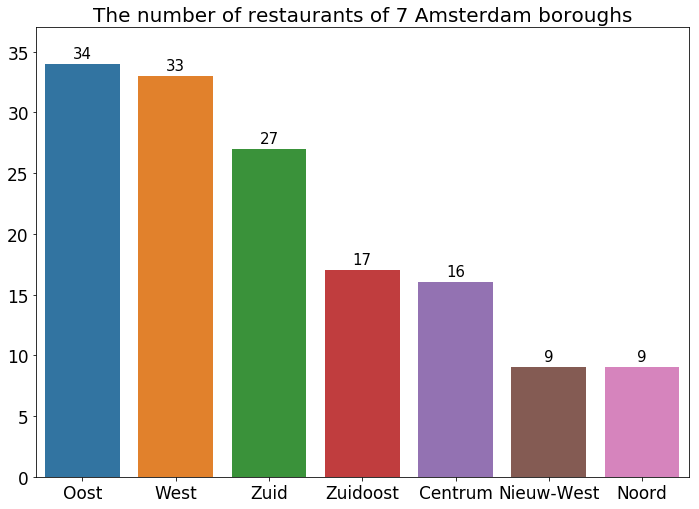

In [19]:
fig_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=fig_dims)

ax_ppr = sns.barplot(x = "Borough", y="Restaurant_Count", \
                     data=ams_rest_cnt_df_sorted, \
                     ax = ax)

plt.title('The number of restaurants of 7 Amsterdam boroughs', fontsize=20)


ax.tick_params(axis='both', which='major', labelsize=17)
ax.set_ylim(0, 37)
ax.set_xlabel('')
ax.set_ylabel('')


for index, row in ams_rest_cnt_df_sorted.iterrows():
    ax_ppr.text(row.name, 
                row.Restaurant_Count + 0.5, \
                row.Restaurant_Count, \
                color='black', \
                ha="center" , \
                fontsize = 15
               )
    
#plt.savefig("Population-Restaurant_ratio.png", dpi=300)
plt.show()

1.3. Visualize population-restaurant ratio of 7 boroughs using a barplot graph

In [21]:
# Sort population-restaurant ratio of 7 boroughs
ams_rest_ratio_df_sorted = ams_rest_cnt_df.sort_values(by=['Avg_Population_per_Restaurant'], ascending=False)
ams_rest_ratio_df_sorted = ams_rest_ratio_df_sorted.reset_index(drop=True)
ams_rest_ratio_df_sorted

,Borough,Restaurant_Count,PopulationDensity,Avg_Population_per_Restaurant
0,Centrum,16,13748,2699
1,Nieuw-West,9,4478,1563
2,West,33,15252,1451
3,Zuid,27,9349,1087
4,Zuidoost,17,4391,811
5,Noord,9,2269,792
6,Oost,34,7635,705


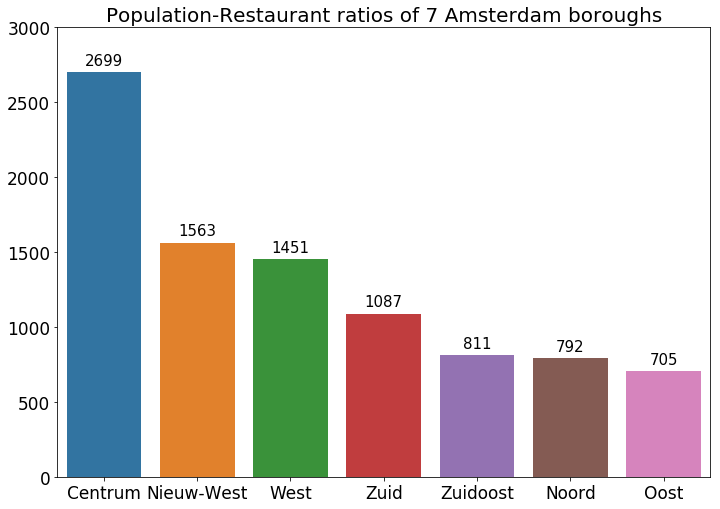

In [22]:
fig_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=fig_dims)

ax_ppr = sns.barplot(x = "Borough", y="Avg_Population_per_Restaurant", \
                     data=ams_rest_ratio_df_sorted, \
                     ax = ax)

plt.title('Population-Restaurant ratios of 7 Amsterdam boroughs', fontsize=20)
#plt.xlabel("Borough", fontsize=15)
#plt.ylabel ("Population per restaurant", fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=17)
ax.set_ylim(0, 3000)
ax.set_xlabel('')
ax.set_ylabel('')

for index, row in ams_rest_ratio_df_sorted.iterrows():
    ax_ppr.text(row.name, 
                row.Avg_Population_per_Restaurant + 50, \
                row.Avg_Population_per_Restaurant, \
                color='black', \
                ha="center" , \
                fontsize = 15
               )
    
#plt.savefig("Population-Restaurant_ratio.png", dpi=300)
plt.show()

#### 2. Explore restaurant ratings of 7 boroughs

Venue ratings in Foursquare are from 0 to 10. Zero is the lowest rating and 10 is the highest rating.

2.1 Calcuate median ratings of 7 boroughs

In [16]:
# Calcuate restaurant median ratings
Median_Rating_df = ams_restaurant.groupby(['Borough'])['Rating'].median().reset_index()
Median_Rating_df.columns = ['Borough', 'Median_Rating']
# Sort boroughs based on restaurant median ratings
Median_Rating_df = Median_Rating_df.sort_values(by=['Median_Rating'], ascending=False).reset_index(drop=True)
Median_Rating_df

,Borough,Median_Rating
0,Centrum,8.80
1,West,8.40
2,Oost,8.30
3,Zuid,7.60
4,Noord,7.45
5,Zuidoost,7.20
6,Nieuw-West,6.80


2.2. Visualize restaurant ratings of 7 boroughs, using a boxplot graph.

Text(0, 0.5, '')

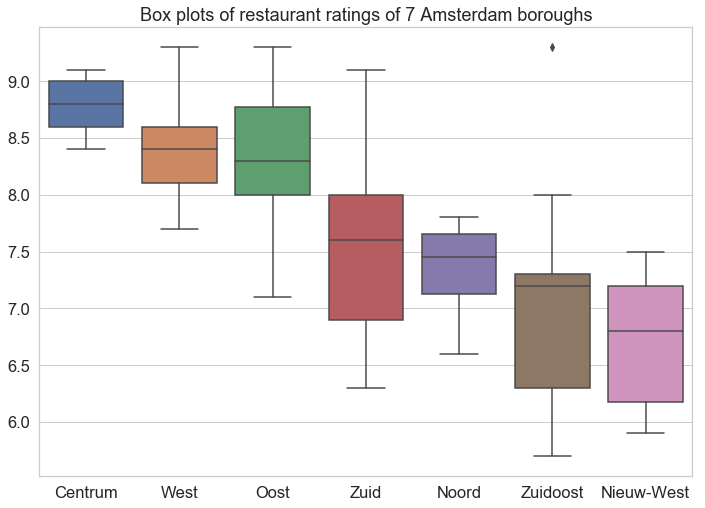

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")

sns.set_context("notebook", font_scale=1.5)
sns.set_style("whitegrid") 
ax = sns.boxplot(x = 'Borough', y = 'Rating', data = ams_restaurant, order = Median_Rating_df['Borough'])
ax.set_title('Box plots of restaurant ratings of 7 Amsterdam boroughs')            
ax.set_xlabel('')
ax.set_ylabel('')

#### 3. Explore expensive restaurant proportions of 7 boroughs

The venue price tiers in Foursquare are from 1 to 4. 1: cheap; 2: moderate; 3: expensive; 4: very expensive. Since high-end restaurants are the focus of our client, the proportion of expensive restaurants (with price tier 3 and 4) is calculated per borough.

3.1 Calcuate percentage of expensive restaurants per borough.

In [39]:
# Calcuate percentage of expensive restaurants per borough.
ams_rest_expensive_df = ams_restaurant[ams_restaurant['Price'].str.contains('Expensive', na=False)].groupby(['Borough']).size().reset_index()
ams_rest_expensive_df.columns = ['Borough', 'Expensive_Restaurants']

ams_rest_expensive_df = ams_rest_expensive_df.merge(ams_rest_cnt_df[['Borough','Restaurant_Count']])
ams_rest_expensive_df['Exp_Rest_Percent'] = ams_rest_expensive_df['Expensive_Restaurants']*100/ams_rest_expensive_df['Restaurant_Count']
ams_rest_expensive_df['Exp_Rest_Percent_formatted'] = ams_rest_expensive_df['Exp_Rest_Percent'].apply(lambda x: '{:.2f}%'.format(x))

ams_rest_expensive_df_sorted = ams_rest_expensive_df.sort_values(by=['Exp_Rest_Percent'], ascending=False).reset_index(drop=True)
ams_rest_expensive_df_sorted

,Borough,Expensive_Restaurants,Restaurant_Count,Exp_Rest_Percent,Exp_Rest_Percent_formatted
0,Centrum,5,16,31.250000,31.25%
1,Oost,5,34,14.705882,14.71%
2,Noord,1,9,11.111111,11.11%
3,Zuid,2,27,7.407407,7.41%
4,West,2,33,6.060606,6.06%
5,Zuidoost,1,17,5.882353,5.88%


3.2 Visualize percentage of expensive restaurants per borough.

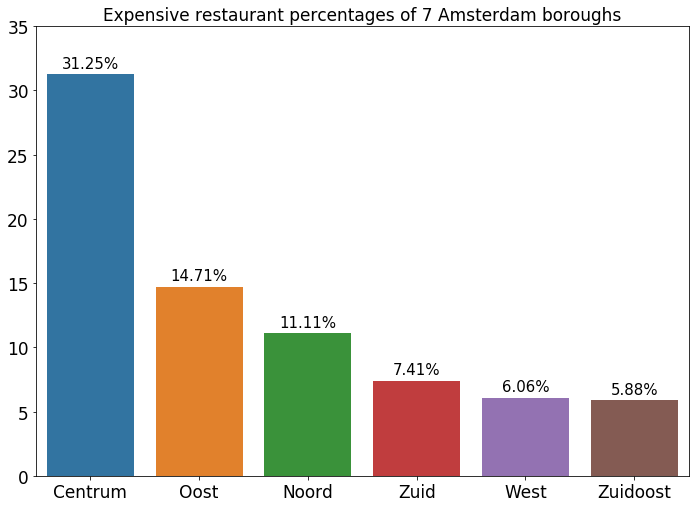

In [45]:
# barplot for expensive restaurant percentage of each borough

fig_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=fig_dims)

ax_ppr = sns.barplot(x = "Borough", y="Exp_Rest_Percent", \
                     data=ams_rest_expensive_df_sorted, \
                     ax = ax)

plt.title('Expensive restaurant percentages of 7 Amsterdam boroughs', fontsize=17)
#plt.xlabel("Borough", fontsize=15)
#plt.ylabel ("Population per restaurant", fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=17)
ax.set_ylim(0, 35)
ax.set_xlabel('')
ax.set_ylabel('')

for index, row in ams_rest_expensive_df_sorted.iterrows():
    ax_ppr.text(row.name, 
                row.Exp_Rest_Percent + 0.5, \
                row.Exp_Rest_Percent_formatted, \
                color='black', \
                ha="center" , \
                fontsize = 15
               )
    
#plt.savefig("Population-Restaurant_ratio.png", dpi=300)
plt.show()

3.4 Explore Japanese restaurants

In [47]:
# briefly check japanese restaurant count
ams_jp_rest_cnt_df = ams_restaurant[ams_restaurant['Venue_Category'].str.contains('Japanese')].groupby('Borough').size().reset_index()
ams_jp_rest_cnt_df.columns=['Borough','Japanese_Restaurant_Count']
ams_jp_rest_cnt_df

,Borough,Japanese_Restaurant_Count
0,West,2
1,Zuid,6


In [59]:
# Calculate Japanese restaurant mean price tiers
ams_jp_rating_df = ams_restaurant[ams_restaurant['Venue_Category'].str.contains('Japanese')].groupby(['Borough'])['Rating'].agg(['mean', 'median']).reset_index()
ams_jp_rating_df.columns=['Borough','JP_Mean_Rating', 'JP_Median_Rating']
ams_jp_rating_df

,Borough,JP_Mean_Rating,JP_Median_Rating
0,West,8.350000,8.35
1,Zuid,7.666667,7.60


In [60]:
# Calculate Japanese restaurant mean price tiers
ams_jp_price_df = ams_restaurant[ams_restaurant['Venue_Category'].str.contains('Japanese')].groupby(['Borough'])['Price_Tier'].agg(['mean', 'median']).reset_index()
ams_jp_price_df.columns=['Borough','JP_Mean_Price_Tier', 'JP_Median_Price_Tier']
ams_jp_price_df

,Borough,JP_Mean_Price_Tier,JP_Median_Price_Tier
0,West,2.0,2.0
1,Zuid,2.0,2.0


# Cluster boroughs based on cuisine types

1. Keep only the 'labeled' restaurant

In [21]:
# Keep only the 'labeled' restaurant
ams_restaurant_categorized = ams_restaurant[ams_restaurant['Venue_Category'] != 'Restaurant'].reset_index(drop=True)
ams_restaurant_categorized

,Borough,Borough_Latitude,Borough_Longitude,Venue_Name,Venue_Latitude,Venue_Longitude,Venue_Category,Rating,Price,Price_Tier
0,Centrum,52.373730,4.895691,La Zoccola del Pacioccone,52.375297,4.893965,Italian Restaurant,8.8,Moderate,2.0
1,Centrum,52.373730,4.895691,Kaagman & Kortekaas,52.374878,4.892455,French Restaurant,9.0,Expensive,3.0
2,Centrum,52.373730,4.895691,Wok to Walk,52.372014,4.895579,Asian Restaurant,8.6,Moderate,2.0
3,Centrum,52.373730,4.895691,Oriental City,52.371912,4.895994,Chinese Restaurant,8.4,Moderate,2.0
4,Centrum,52.373730,4.895691,Ashoka Restaurant (Amsterdam Centrum),52.376086,4.892356,Indian Restaurant,9.1,Moderate,2.0
5,Centrum,52.373730,4.895691,FuLu Mandarijn Amsterdam,52.371684,4.892720,Chinese Restaurant,8.7,Moderate,2.0
6,Centrum,52.373730,4.895691,Maenaam Thai,52.375184,4.891260,Thai Restaurant,8.7,Moderate,2.0
7,Centrum,52.373730,4.895691,Mata Hari,52.374549,4.900177,Mediterranean Restaurant,8.5,Moderate,2.0
8,Centrum,52.373730,4.895691,OCHA,52.374024,4.901683,Thai Restaurant,9.0,Moderate,2.0
9,Centrum,52.373730,4.895691,Eetcafé Bern,52.372575,4.900645,Swiss Restaurant,8.6,Expensive,3.0


In [22]:
# one hot encoding
ams_restaurant_onehot = pd.get_dummies(ams_restaurant_categorized[['Venue_Category']], prefix="", prefix_sep="")
# add Borough column back to dataframe
ams_restaurant_onehot.insert(0, "Borough", ams_restaurant_categorized['Borough'], True) 
ams_restaurant_onehot.head()

,Borough,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Doner Restaurant,...,Portuguese Restaurant,Scandinavian Restaurant,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Swiss Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
0,Centrum,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Centrum,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Centrum,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Centrum,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Centrum,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


2. Calculate the proportion of each type of restaurant

In [35]:
# Calculate the proportion of each type of restaurant
ams_restaurant_proportion = ams_restaurant_onehot.groupby('Borough').mean().reset_index()
ams_restaurant_proportion

,Borough,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Doner Restaurant,...,Portuguese Restaurant,Scandinavian Restaurant,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Swiss Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
0,Centrum,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.153846,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.153846,0.000000,0.000000
1,Nieuw-West,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000
2,Noord,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.333333,0.000000
3,Oost,0.000000,0.000000,0.096774,0.032258,0.032258,0.032258,0.000000,0.032258,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.032258,0.000000,0.032258,0.032258,0.129032,0.096774
4,West,0.033333,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.033333,0.000000,...,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.066667
5,Zuid,0.000000,0.045455,0.090909,0.000000,0.000000,0.000000,0.045455,0.000000,0.000000,...,0.045455,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000
6,Zuidoost,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.200000,0.000000,0.066667,...,0.000000,0.066667,0.066667,0.066667,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000


3. Print each borough along with the top 5 most common restaurants

In [43]:
# print each borough along with the top 5 most common venues

num_top_venues = 5

for places in ams_restaurant_proportion['Borough']:
    print("%%%%%%%%% "+places+" %%%%%%%%")
    temp = ams_restaurant_proportion[ams_restaurant_proportion['Borough'] == places].T.reset_index()
    temp.columns = ['Restaurant_Category','Proportion']
    temp = temp.iloc[1:]
    temp['Proportion'] = temp['Proportion'].astype(float)
    temp['Percentage'] = temp['Proportion'].apply(lambda x: '{:.2f}%'.format(x*100))
    top_n_df = temp.sort_values('Proportion', ascending=False).reset_index(drop=True).head(num_top_venues)
    top_n_df = top_n_df[['Restaurant_Category', 'Percentage']]
    print(top_n_df)
    print('\n')

%%%%%%%%% Centrum %%%%%%%%
  Restaurant_Category Percentage
0   French Restaurant     30.77%
1     Thai Restaurant     15.38%
2  Chinese Restaurant     15.38%
3  Italian Restaurant      7.69%
4    Asian Restaurant      7.69%


%%%%%%%%% Nieuw-West %%%%%%%%
         Restaurant_Category Percentage
0         Chinese Restaurant     28.57%
1           Asian Restaurant     14.29%
2         Turkish Restaurant     14.29%
3        Moroccan Restaurant     14.29%
4  Indian Chinese Restaurant     14.29%


%%%%%%%%% Noord %%%%%%%%
    Restaurant_Category Percentage
0    Turkish Restaurant     33.33%
1  Fast Food Restaurant     33.33%
2       Thai Restaurant     16.67%
3     French Restaurant     16.67%
4   American Restaurant      0.00%


%%%%%%%%% Oost %%%%%%%%
             Restaurant_Category Percentage
0             Italian Restaurant     16.13%
1              French Restaurant     12.90%
2             Turkish Restaurant     12.90%
3  Vegetarian / Vegan Restaurant      9.68%
4               Asia

4. Cluster boroughs using kmeans

In [28]:
# Features for kmeans clustering
features_df = ams_restaurant_freq.iloc[:, 1:]
features_df

,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Doner Restaurant,Dutch Restaurant,...,Portuguese Restaurant,Scandinavian Restaurant,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Swiss Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
0,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.153846,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.153846,0.000000,0.000000
1,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.333333,0.000000
3,0.000000,0.000000,0.096774,0.032258,0.032258,0.032258,0.000000,0.032258,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.032258,0.000000,0.032258,0.032258,0.129032,0.096774
4,0.033333,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.033333,0.000000,0.033333,...,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.066667
5,0.000000,0.045455,0.090909,0.000000,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,...,0.045455,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000
6,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.200000,0.000000,0.066667,0.000000,...,0.000000,0.066667,0.066667,0.066667,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000


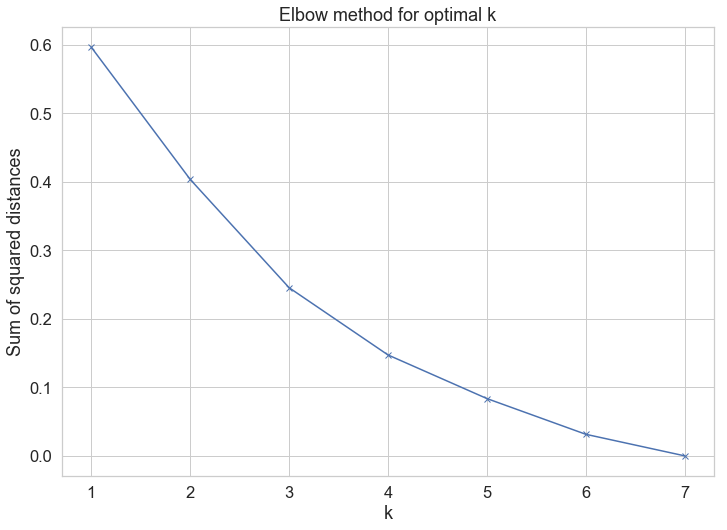

In [33]:
# Elbow method to determine the optimal k

sum_of_squared_distances = []
K = range(1, 8)
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(features_df)
    sum_of_squared_distances.append(km.inertia_)
   
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method for optimal k')
plt.show()

The 'elbow' location is bit ambiguous in the above figure. Here we choose k = 5 as the optimal k for kmeans clustering.

In [46]:
# set number of clusters
kclusters = 5 # italian, turkish, chinese, french

#features_df = ams_restaurant_grouped.iloc[:, 1:]
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(features_df)

# check cluster labels generated for each row in the dataframe
for borough, label in zip(ams_restaurant_grouped['Borough'].to_list(), kmeans.labels_):
    print(borough + ': ' + str(label+1))

Centrum: 4
Nieuw-West: 3
Noord: 2
Oost: 1
West: 1
Zuid: 5
Zuidoost: 3


- Cluster 1: Oost and West boroughs. Italian cuisine is the top 1 cuisine (16.13% and 20.00%, respectively).
- Cluster 2: Noord borough. Turkish cuisine and fast food are dominant (in total 66.66%).
- Cluster 3: Zuidoost and Nieuw-West boroughs. Chinese cuisine is the most popular cuisine (20.00% and 20.57%, respectively).
- Cluster 4: Centrum borough. French cuisine takes a high percentage among all the cuisine types (30.77%).
- Cluster 5: Zuid borough. Japanese and Italian are the top 2 cuisines, around 50% of the total cuisines.